<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:3**

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, boxcox
import os
import joblib
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

In [34]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [35]:
flotation = pd.read_csv('Flotation_Plant_Clean.csv')

##**5. Exploratory Data Analysis**

###**5.1. Dataset summary statistics**

In [36]:
round(flotation.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
iron_feed,726453.0,56.30,5.16,42.74,52.67,56.08,59.72,65.78
silica_feed,726453.0,14.65,6.81,1.31,8.94,13.85,19.60,33.40
starch_flow,726453.0,338.26,146.90,0.20,235.13,326.51,395.92,999.98
amina_flow,726453.0,488.14,91.30,241.67,431.80,504.33,553.34,739.54
pulp_flow,726453.0,397.57,9.71,376.25,394.24,399.24,402.97,418.64
pulp_pH,726453.0,9.77,0.39,8.75,9.53,9.80,10.04,10.81
pulp_density,726453.0,1.68,0.07,1.52,1.65,1.70,1.73,1.85
airflow_col1,726453.0,280.11,29.66,175.51,250.28,299.34,300.15,373.87
airflow_col2,726453.0,277.11,30.17,175.16,250.45,296.20,300.68,375.99
airflow_col3,726453.0,281.05,28.59,176.47,250.85,298.69,300.39,364.35


In [37]:
flotation.head().T

,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
iron_feed,55.2,55.2,55.2,55.2,55.2
silica_feed,16.98,16.98,16.98,16.98,16.98
starch_flow,301.953,302.441,304.346,304.736,303.369
amina_flow,557.434,563.965,568.054,568.665,558.167
pulp_flow,395.713,397.383,399.668,397.939,400.254
pulp_pH,10.07,10.07,10.07,10.07,10.07
pulp_density,1.74,1.74,1.74,1.74,1.74
airflow_col1,249.214,249.719,249.741,249.917,250.203
airflow_col2,253.235,250.532,247.874,254.487,252.136


In [38]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726453 entries, 0 to 726452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          726453 non-null  object 
 1   iron_feed     726453 non-null  float64
 2   silica_feed   726453 non-null  float64
 3   starch_flow   726453 non-null  float64
 4   amina_flow    726453 non-null  float64
 5   pulp_flow     726453 non-null  float64
 6   pulp_pH       726453 non-null  float64
 7   pulp_density  726453 non-null  float64
 8   airflow_col1  726453 non-null  float64
 9   airflow_col2  726453 non-null  float64
 10  airflow_col3  726453 non-null  float64
 11  airflow_col4  726453 non-null  float64
 12  airflow_col5  726453 non-null  float64
 13  airflow_col6  726453 non-null  float64
 14  airflow_col7  726453 non-null  float64
 15  level_col1    726453 non-null  float64
 16  level_col2    726453 non-null  float64
 17  level_col3    726453 non-null  float64
 18  leve

###**5.2. Corellation between the variables**

In [39]:
flotation.corr()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_col1,airflow_col2,airflow_col3,...,airflow_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,iron_conc,silica_conc
iron_feed,1.000000,-0.971883,-0.008466,-0.087737,0.161280,0.007553,-0.125132,-0.061938,-0.168951,-0.061800,...,-0.015953,0.029428,0.020757,0.015124,0.016179,0.023564,0.003504,0.025801,0.055895,-0.077120
silica_feed,-0.971883,1.000000,0.018555,0.078228,-0.151153,0.008043,0.103815,0.091385,0.182259,0.083836,...,0.044889,-0.037984,-0.036595,-0.022452,-0.033770,-0.043649,-0.019029,-0.046180,-0.044607,0.072722
starch_flow,-0.008466,0.018555,1.000000,0.026716,0.027589,0.142341,-0.062867,0.066048,0.071333,0.085754,...,0.083557,-0.115524,-0.094081,-0.080047,0.020060,0.026304,0.031570,0.008449,0.022377,-0.027706
amina_flow,-0.087737,0.078228,0.026716,1.000000,0.212814,0.124565,0.655336,0.112255,0.124113,0.102720,...,0.080287,-0.269077,-0.234851,-0.287949,-0.180395,-0.211850,-0.198670,-0.168062,-0.110440,0.156840
pulp_flow,0.161280,-0.151153,0.027589,0.212814,1.000000,0.118013,0.013252,-0.138037,-0.118703,-0.141062,...,-0.140902,-0.009272,-0.008793,-0.055087,-0.011130,0.000710,-0.017260,0.015416,0.082664,0.008710
pulp_pH,0.007553,0.008043,0.142341,0.124565,0.118013,1.000000,0.116751,0.163176,0.144866,0.193486,...,0.174792,-0.166607,-0.154442,-0.141116,0.044802,0.011362,-0.075530,0.017930,0.192456,-0.147278
pulp_density,-0.125132,0.103815,-0.062867,0.655336,0.013252,0.116751,1.000000,-0.003118,0.028037,-0.029950,...,-0.051139,-0.113188,-0.094238,-0.151323,-0.087327,-0.140947,-0.101188,-0.086097,0.015593,0.046378
airflow_col1,-0.061938,0.091385,0.066048,0.112255,-0.138037,0.163176,-0.003118,1.000000,0.848209,0.954339,...,0.646845,-0.442280,-0.426790,-0.372669,-0.064000,-0.093430,-0.119235,-0.111973,0.098234,-0.219485
airflow_col2,-0.168951,0.182259,0.071333,0.124113,-0.118703,0.144866,0.028037,0.848209,1.000000,0.860341,...,0.578693,-0.432909,-0.423994,-0.366476,-0.076790,-0.113068,-0.117966,-0.114000,0.058316,-0.167637
airflow_col3,-0.061800,0.083836,0.085754,0.102720,-0.141062,0.193486,-0.029950,0.954339,0.860341,1.000000,...,0.649439,-0.441445,-0.421858,-0.365527,-0.048588,-0.065457,-0.100485,-0.086347,0.099771,-0.219278


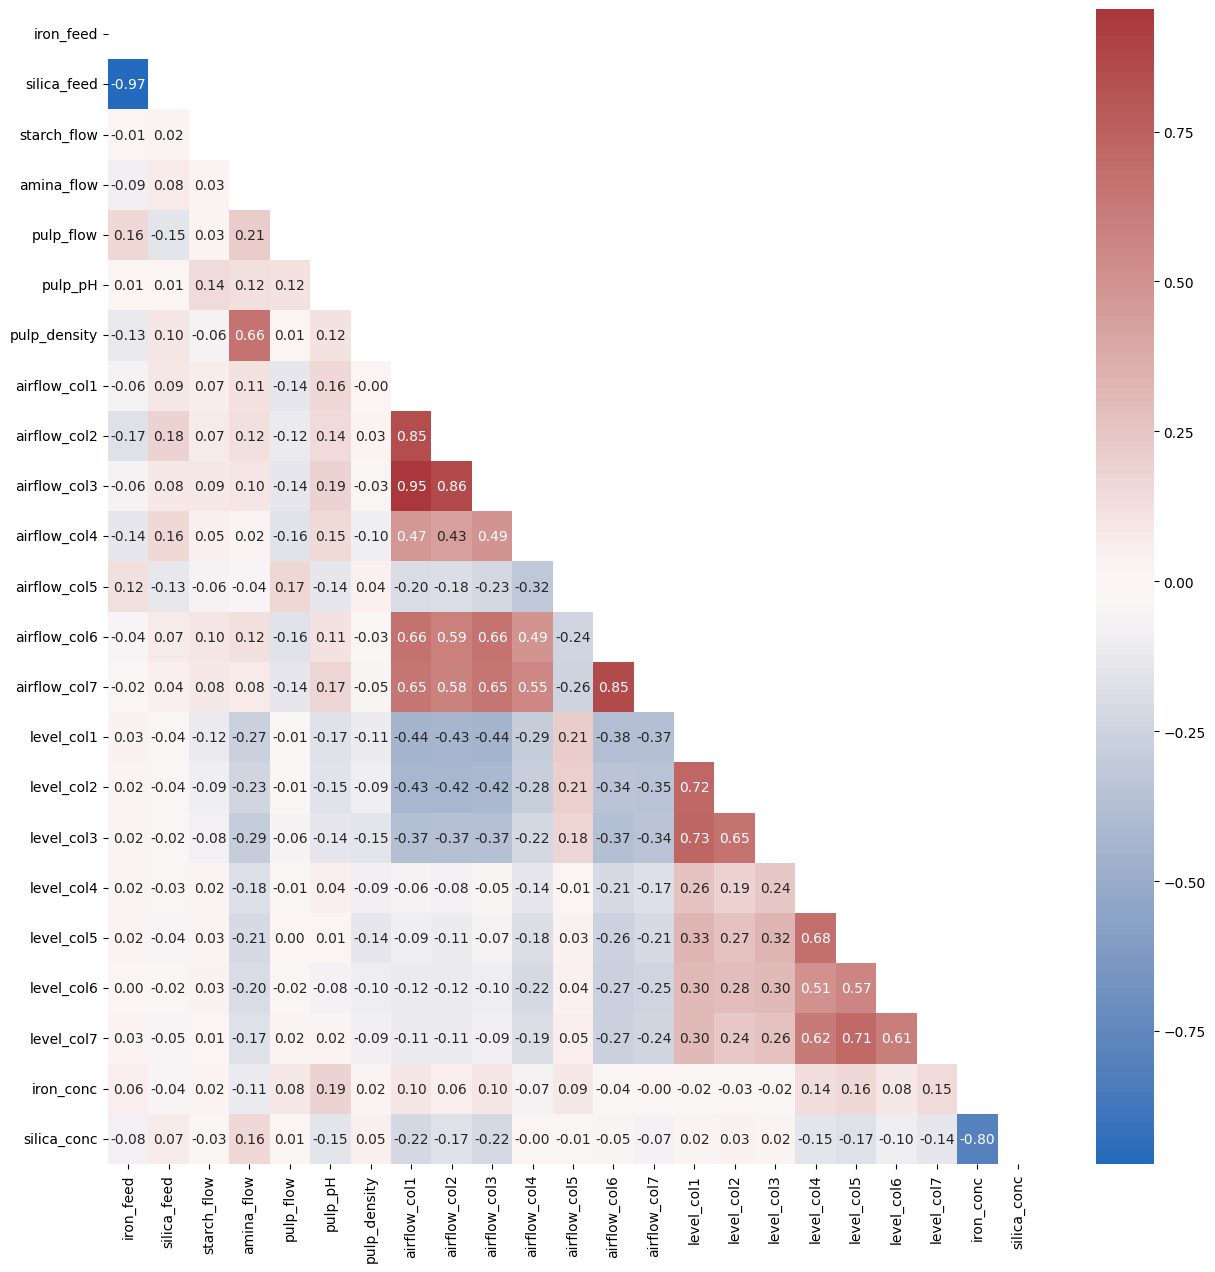

In [40]:
mask = np.triu(np.ones_like(flotation.corr(), dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(flotation.corr(), annot=True, fmt='.2f', cmap='vlag', 
            annot_kws={"fontsize": 10}, mask=mask)
plt.show()


In [41]:
correlation = flotation.corr().abs()
mask = correlation.mask(np.triu(np.ones(correlation.shape, dtype=bool)))
sorted_correlation = mask.unstack().sort_values(ascending=False)
sorted_correlation = sorted_correlation[(sorted_correlation > 0.65) & (sorted_correlation < 1.0)].reset_index()

# Rename the columns
sorted_correlation.columns = ['variable_1', 'variable_2', 'correlation_degree']

# Reorder the columns
sorted_correlation = sorted_correlation[['variable_1', 'variable_2', 'correlation_degree']]

sorted_correlation

,variable_1,variable_2,correlation_degree
0,iron_feed,silica_feed,0.971883
1,airflow_col1,airflow_col3,0.954339
2,airflow_col2,airflow_col3,0.860341
3,airflow_col6,airflow_col7,0.854030
4,airflow_col1,airflow_col2,0.848209
5,iron_conc,silica_conc,0.800688
6,level_col1,level_col3,0.725207
7,level_col1,level_col2,0.717291
8,level_col5,level_col7,0.710180
9,level_col4,level_col5,0.681514


- Drop highly correlated columns

In [42]:
flotation.drop(['iron_feed', 'airflow_col1', 'airflow_col2', 'airflow_col7', 'level_col1', 
                'level_col2', 'level_col4', 'level_col6', 'iron_conc'], axis=1, inplace=True)

In [43]:
flotation.columns

Index(['date', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow_col3', 'airflow_col4',
       'airflow_col5', 'airflow_col6', 'level_col3', 'level_col5',
       'level_col7', 'silica_conc'],
      dtype='object')

###**5.3. Dataset normalisation**

- Normalizing the dataset is necessary to bring the features or variables to a similar scale or range.

In [44]:
from sklearn.preprocessing import MinMaxScaler

#Select the columns to normalize
columns_to_normalize = ['silica_feed', 'starch_flow', 'amina_flow', 
                        'pulp_flow', 'pulp_pH', 'pulp_density', 
                        'airflow_col3', 'airflow_col4', 'airflow_col5', 
                        'airflow_col6', 'level_col3', 'level_col5',
                        'level_col7', 'silica_conc']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
flotation[columns_to_normalize] = scaler.fit_transform(flotation[columns_to_normalize])


###**5.4. Check & remove outliers**

- Visualize the variables for seeing outliers

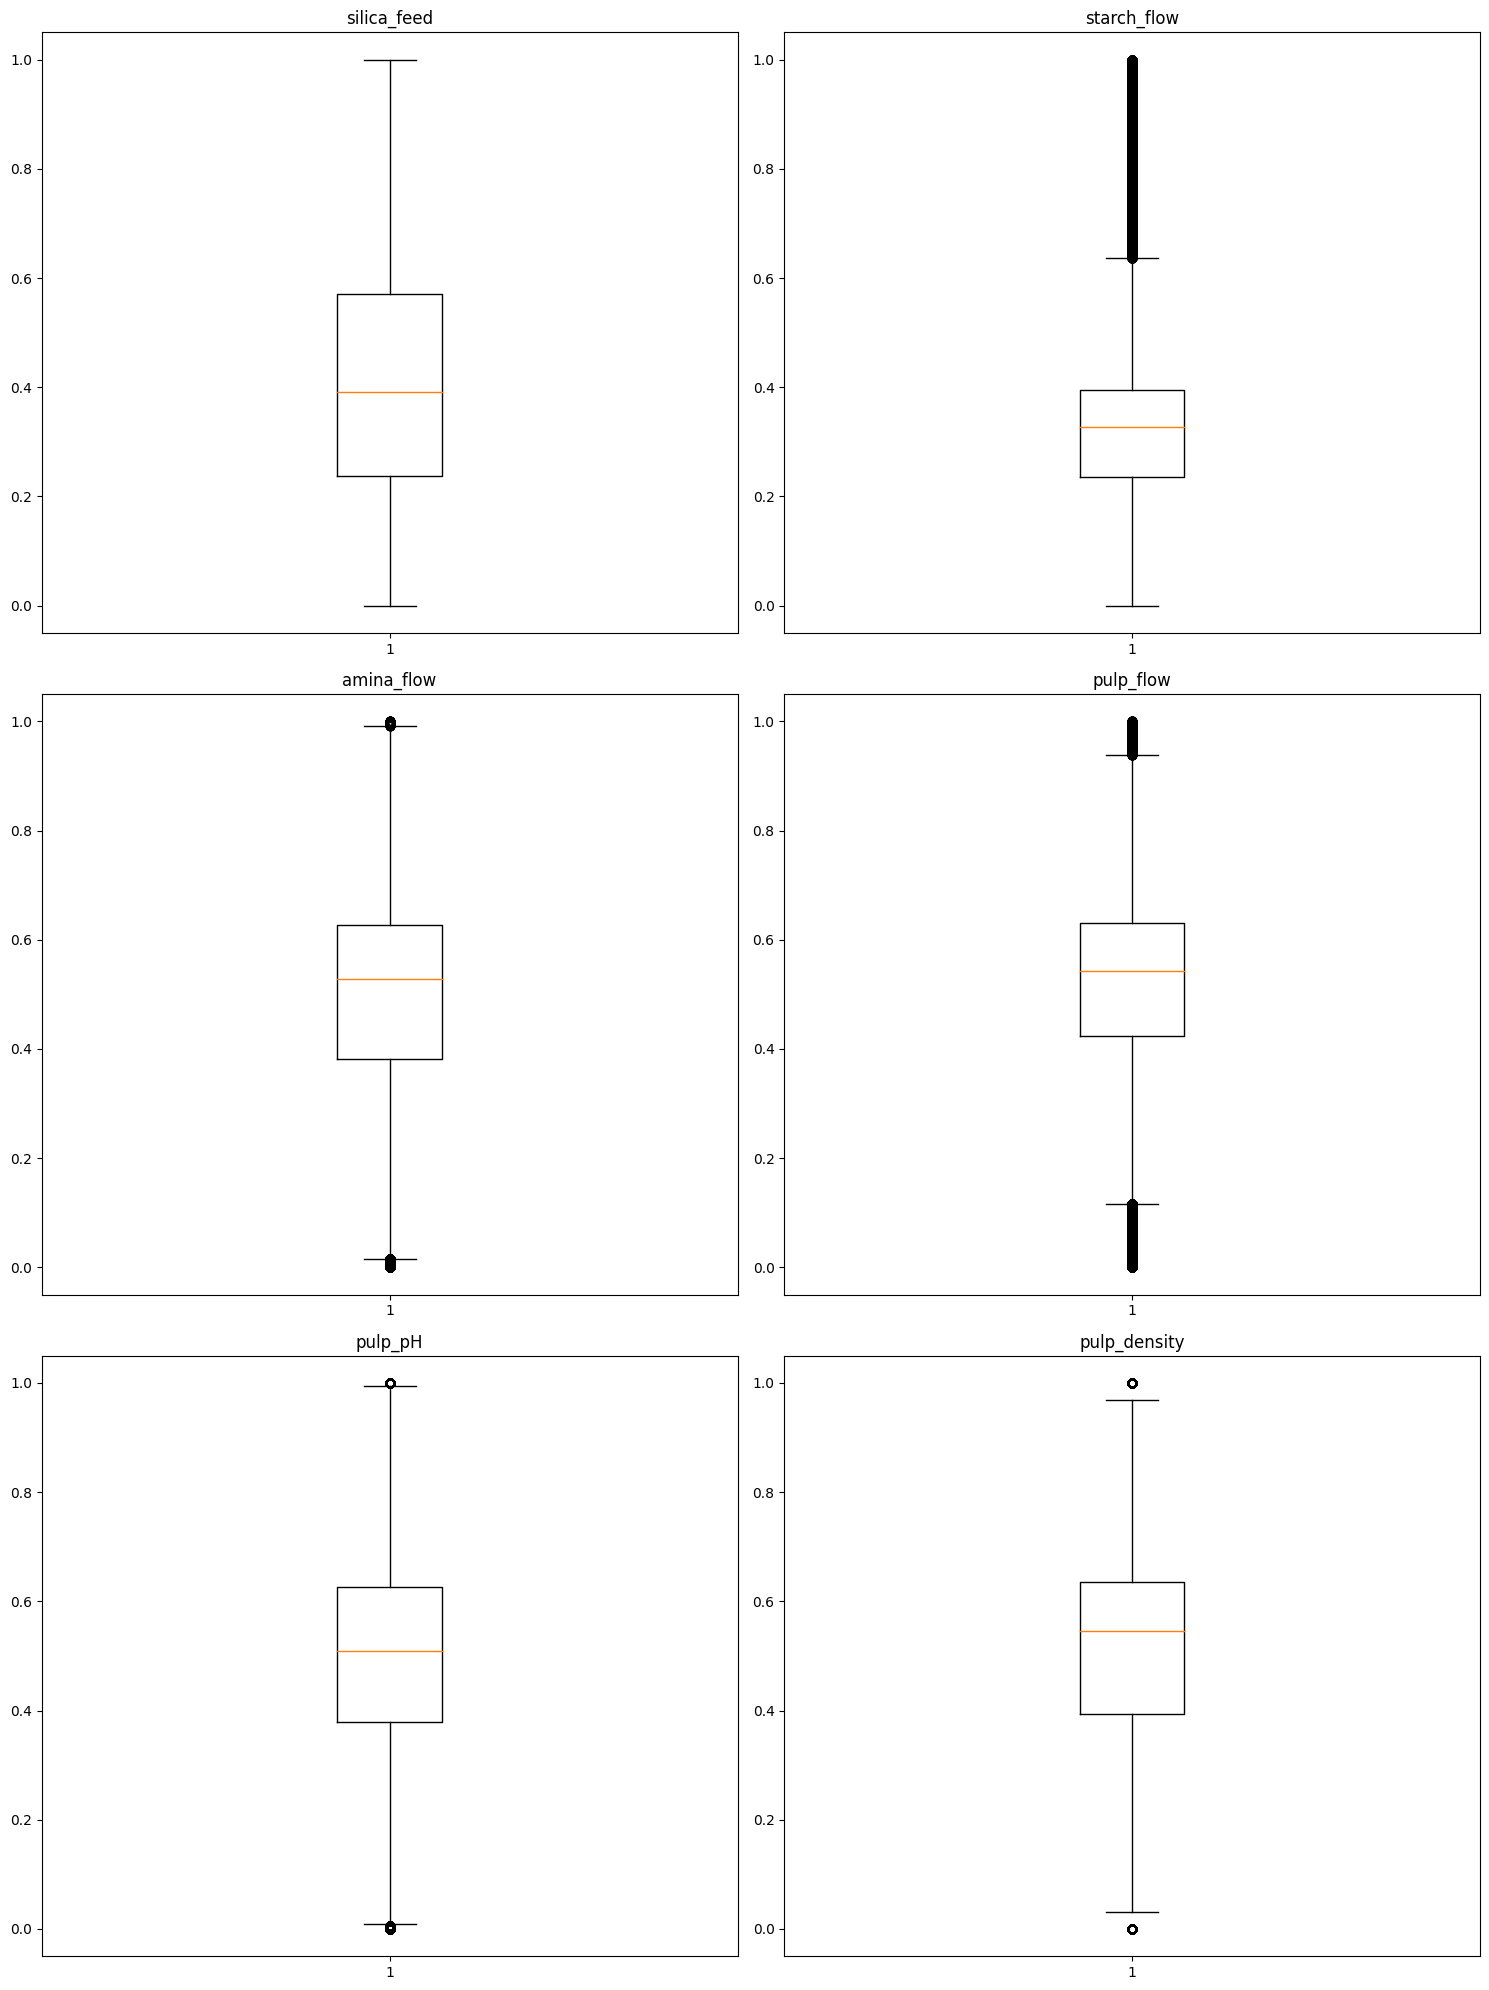

In [45]:
variables = ["silica_feed", "starch_flow", "amina_flow", 
             "pulp_flow", "pulp_pH", "pulp_density"]

fig, axes = plt.subplots(3, 2, figsize=(15, 20))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

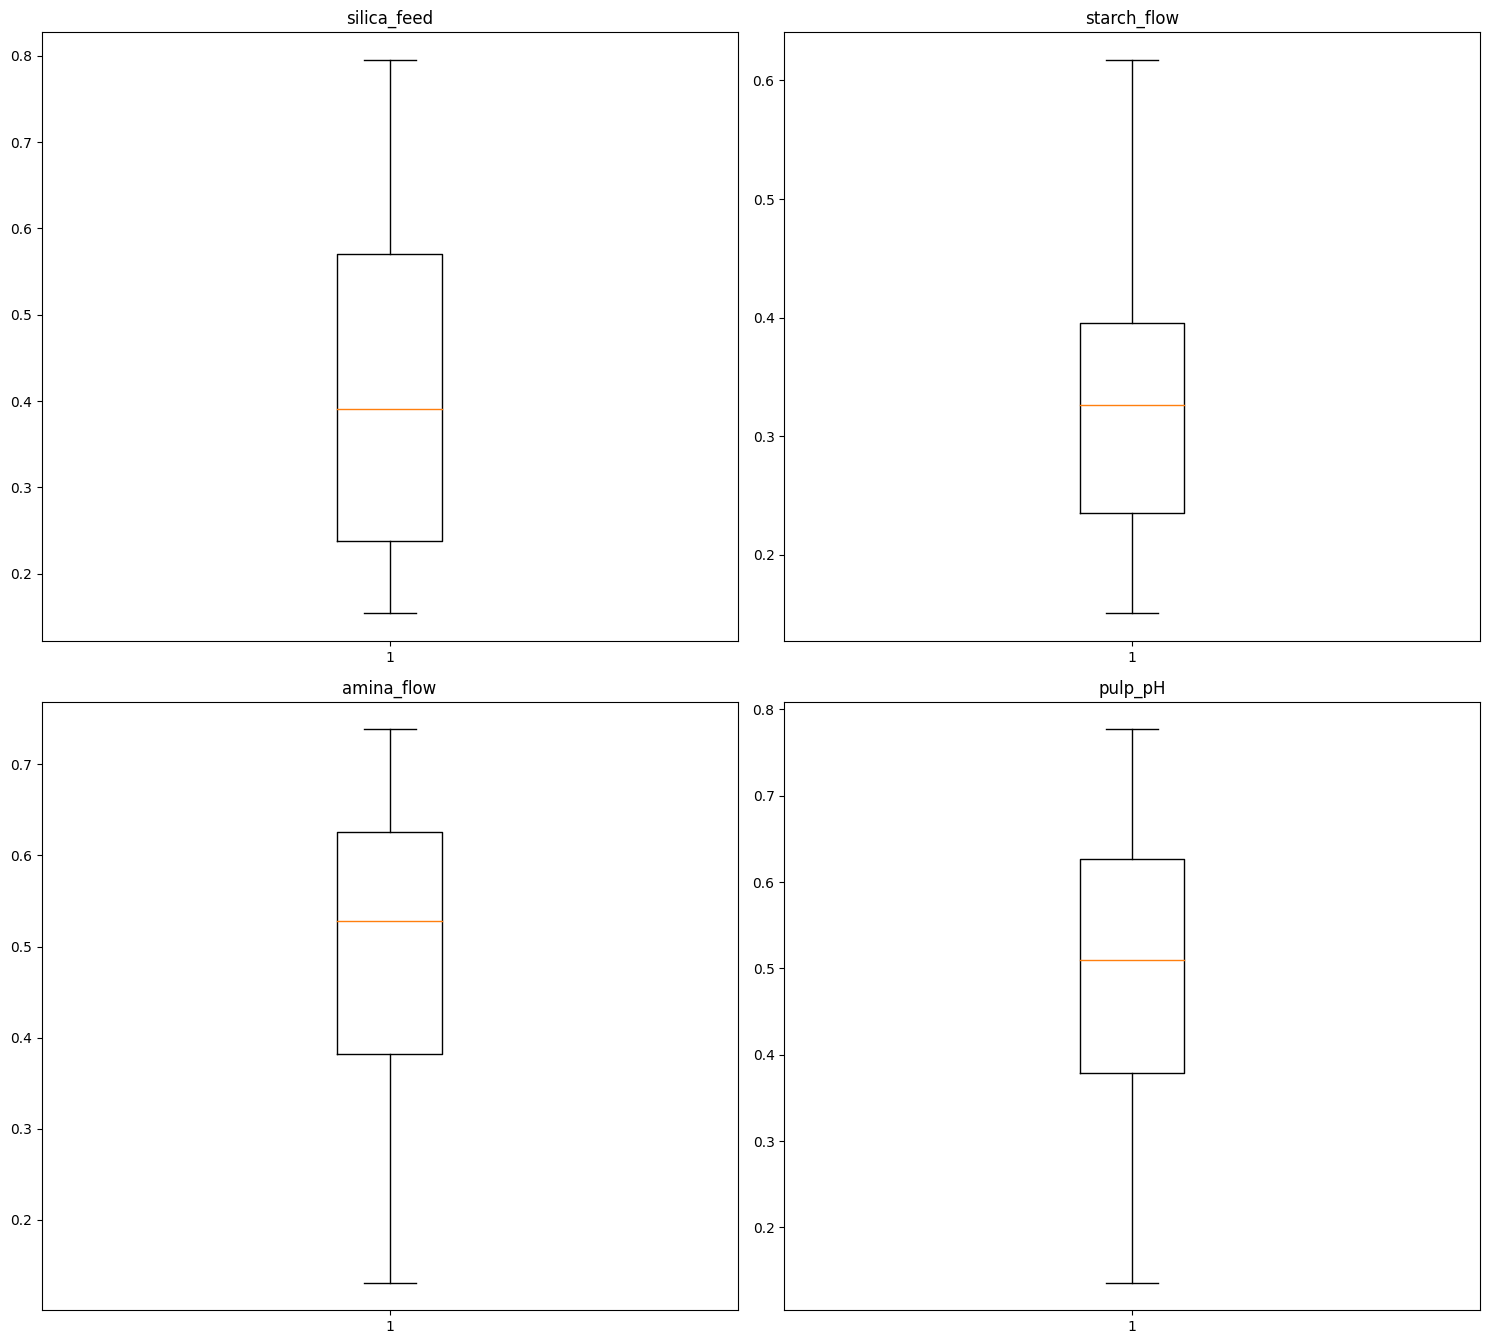

In [46]:
from scipy.stats.mstats import winsorize

variables = ["silica_feed", "starch_flow", "amina_flow", "pulp_pH",]

fig, axes = plt.subplots(2, 2, figsize=(15, 20))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    data_winsorized = winsorize(data, limits=[0.05, 0.05])
    plt.boxplot(data_winsorized)
    plt.title(variable)

plt.tight_layout()
plt.show()

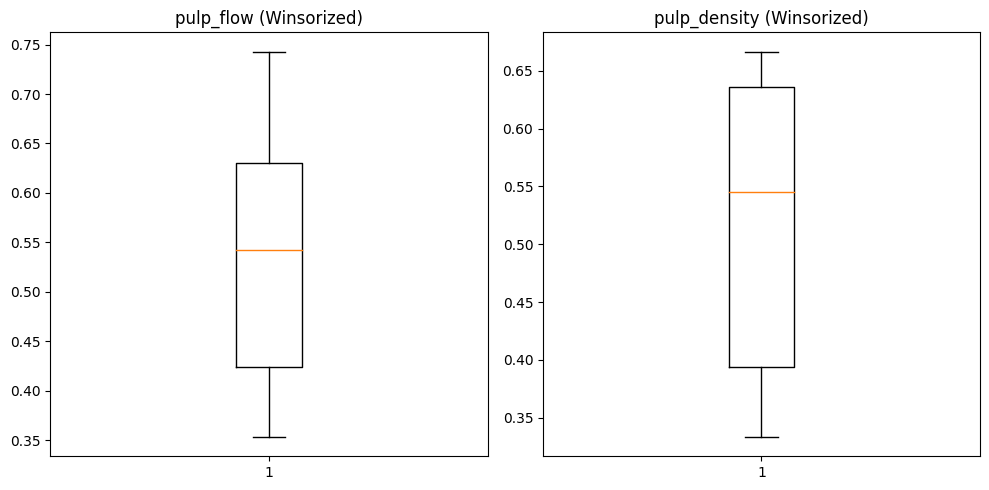

In [47]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

# Winsorize "pulp_flow" column
pulp_flow_data = flotation["pulp_flow"]
pulp_flow_winsorized = winsorize(pulp_flow_data, limits=[0.2, 0.1])

# Winsorize "pulp_density" column
pulp_density_data = flotation["pulp_density"]
pulp_density_winsorized = winsorize(pulp_density_data, limits=[0.2, 0.2])

plt.figure(figsize=(10, 5))

# Plot boxplot for "pulp_flow" column
plt.subplot(1, 2, 1)
plt.boxplot(pulp_flow_winsorized)
plt.title("pulp_flow (Winsorized)")

# Plot boxplot for "pulp_density" column
plt.subplot(1, 2, 2)
plt.boxplot(pulp_density_winsorized)
plt.title("pulp_density (Winsorized)")

plt.tight_layout()
plt.show()

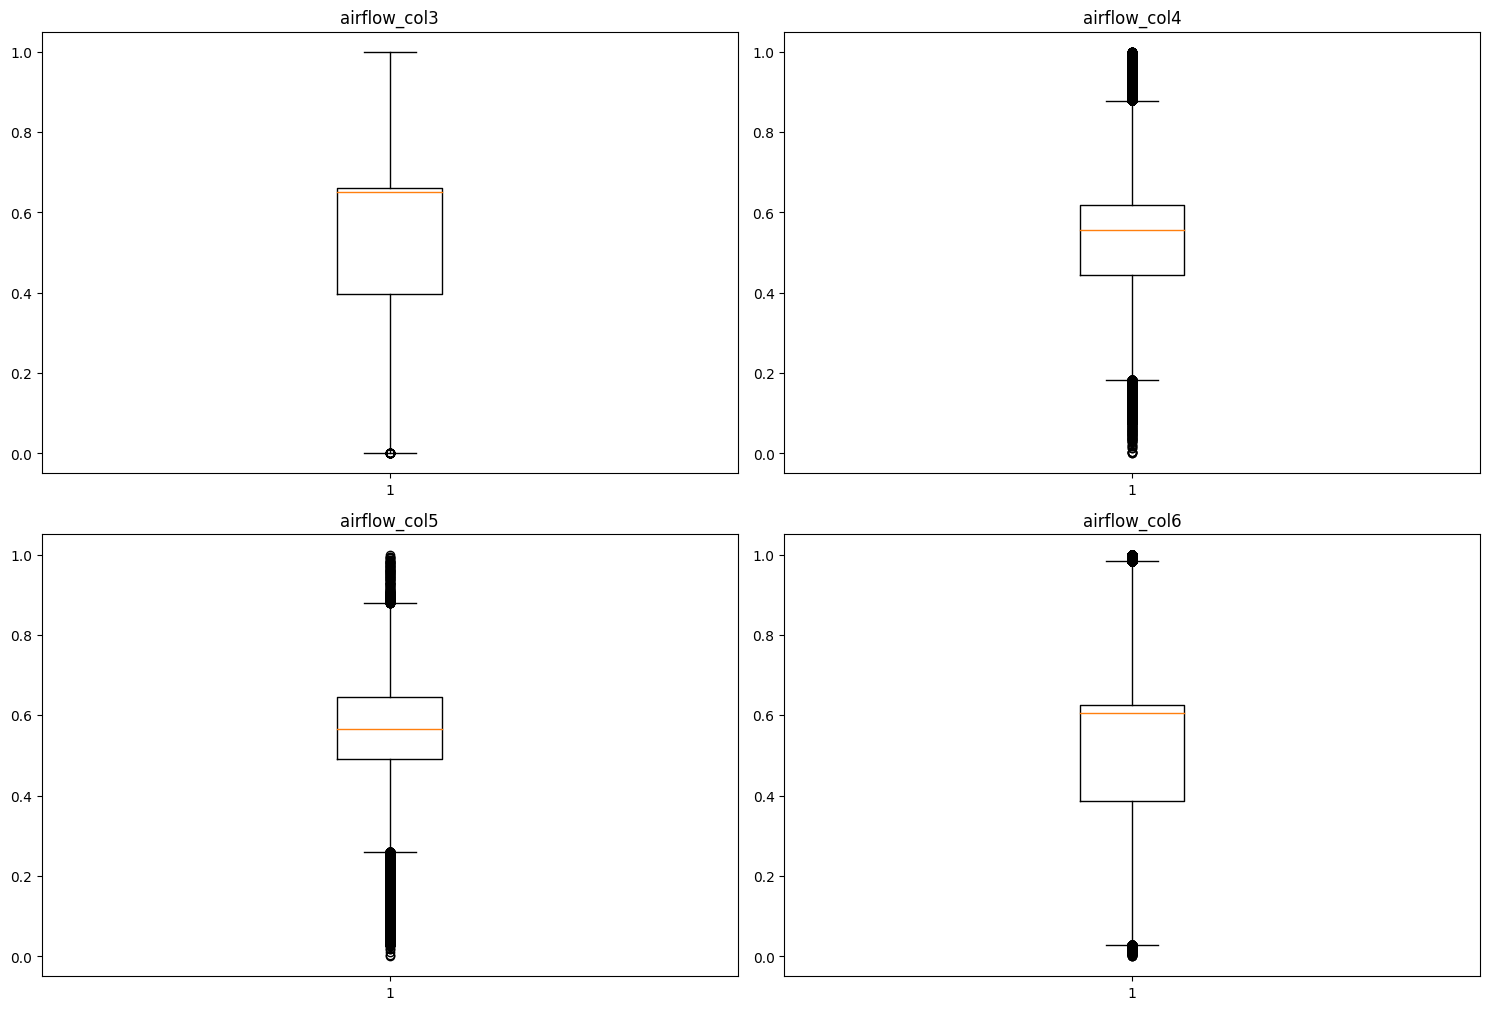

In [48]:
variables = ["airflow_col3", "airflow_col4", 
             "airflow_col5", "airflow_col6"]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

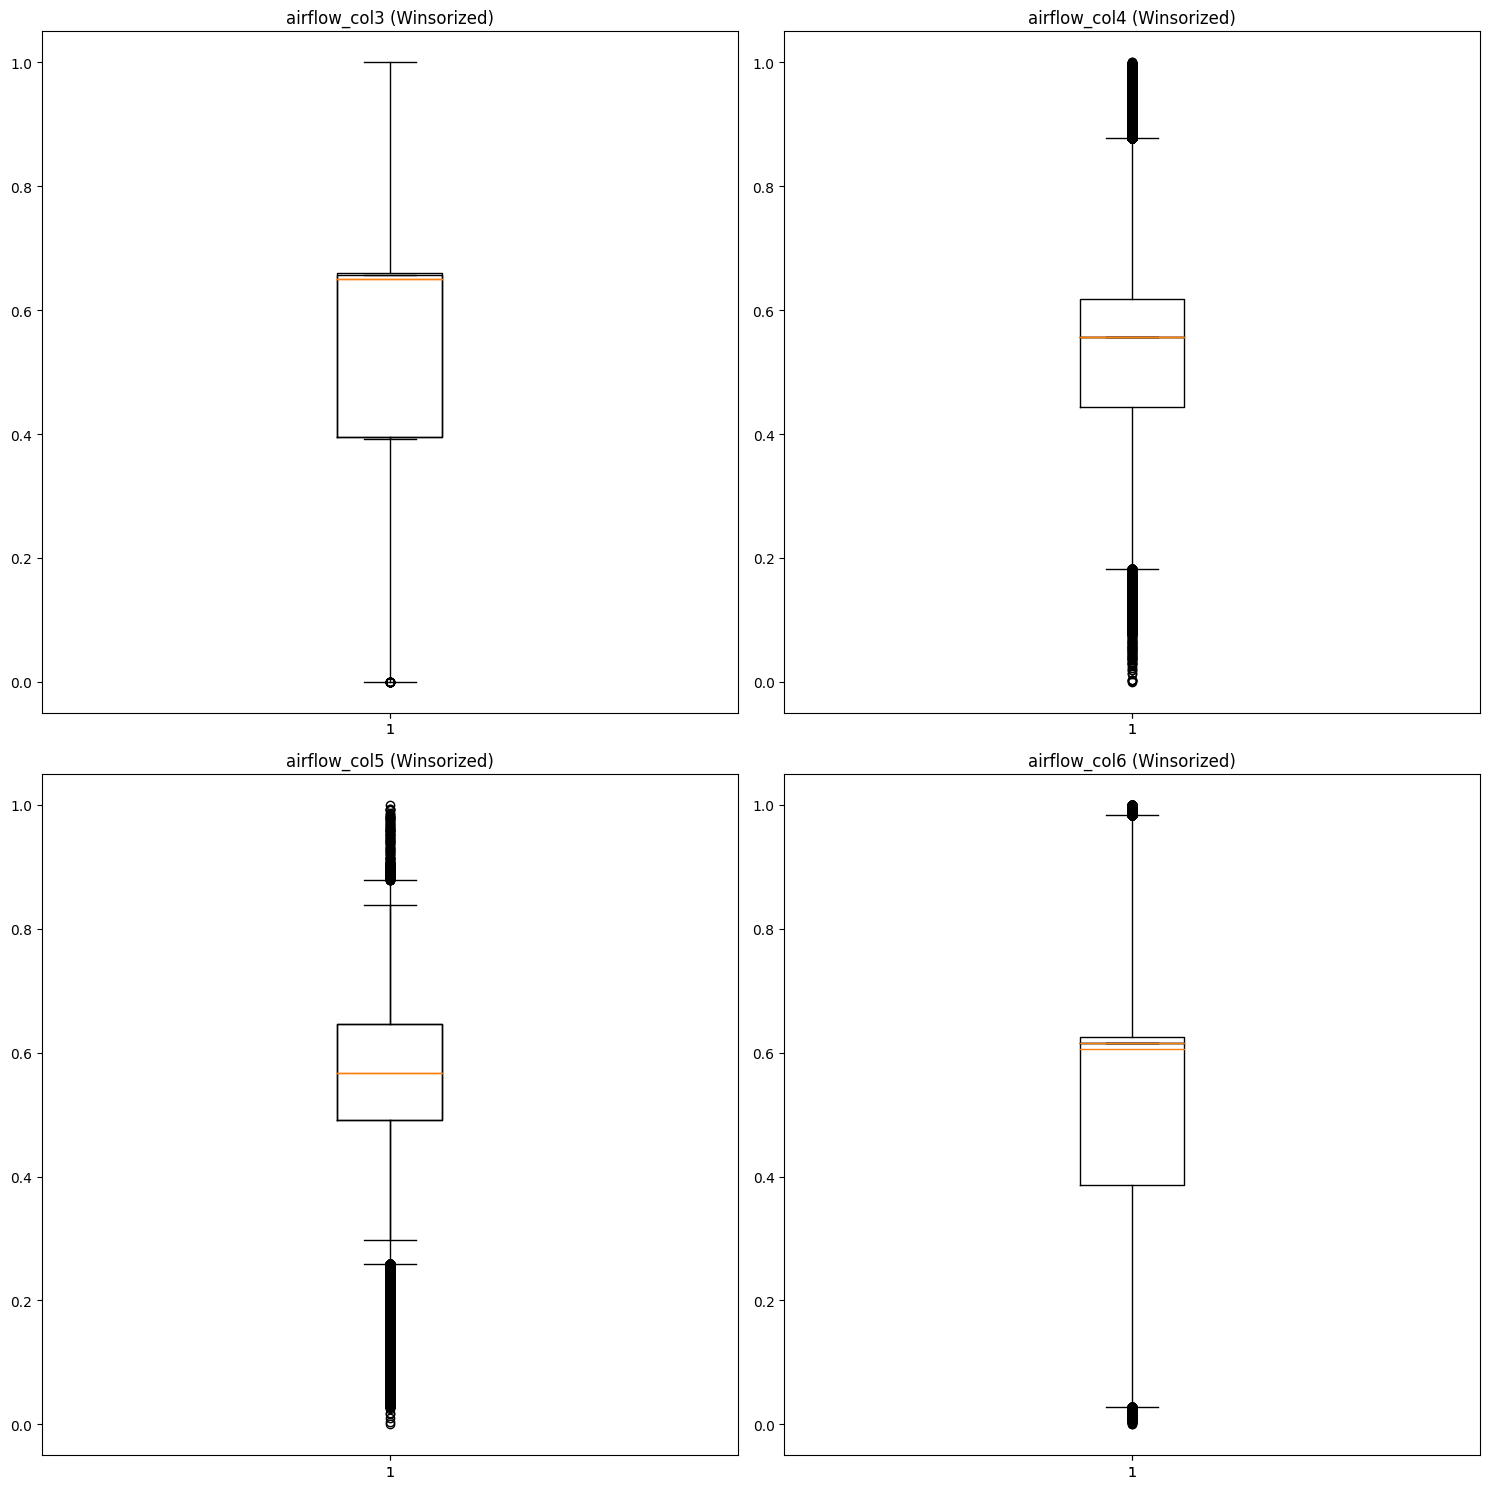

In [49]:
from scipy.stats.mstats import winsorize

variables = ["airflow_col3", "airflow_col4", "airflow_col5", "airflow_col6"]
limits = {"airflow_col3": [0.2, 0.3], "airflow_col4": [0.5, 0.5], 
          "airflow_col5": [0.05, 0.1], "airflow_col6": [0.7, 0.7]}

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, variable in enumerate(variables):
    plt.subplot(2, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

    # Winsorize the data
    data_winsorized = winsorize(data, limits=limits[variable])

    # Plot the winsorized data
    plt.subplot(2, 2, i+1)
    plt.boxplot(data_winsorized)
    plt.title(variable + " (Winsorized)")

plt.tight_layout()
plt.show()

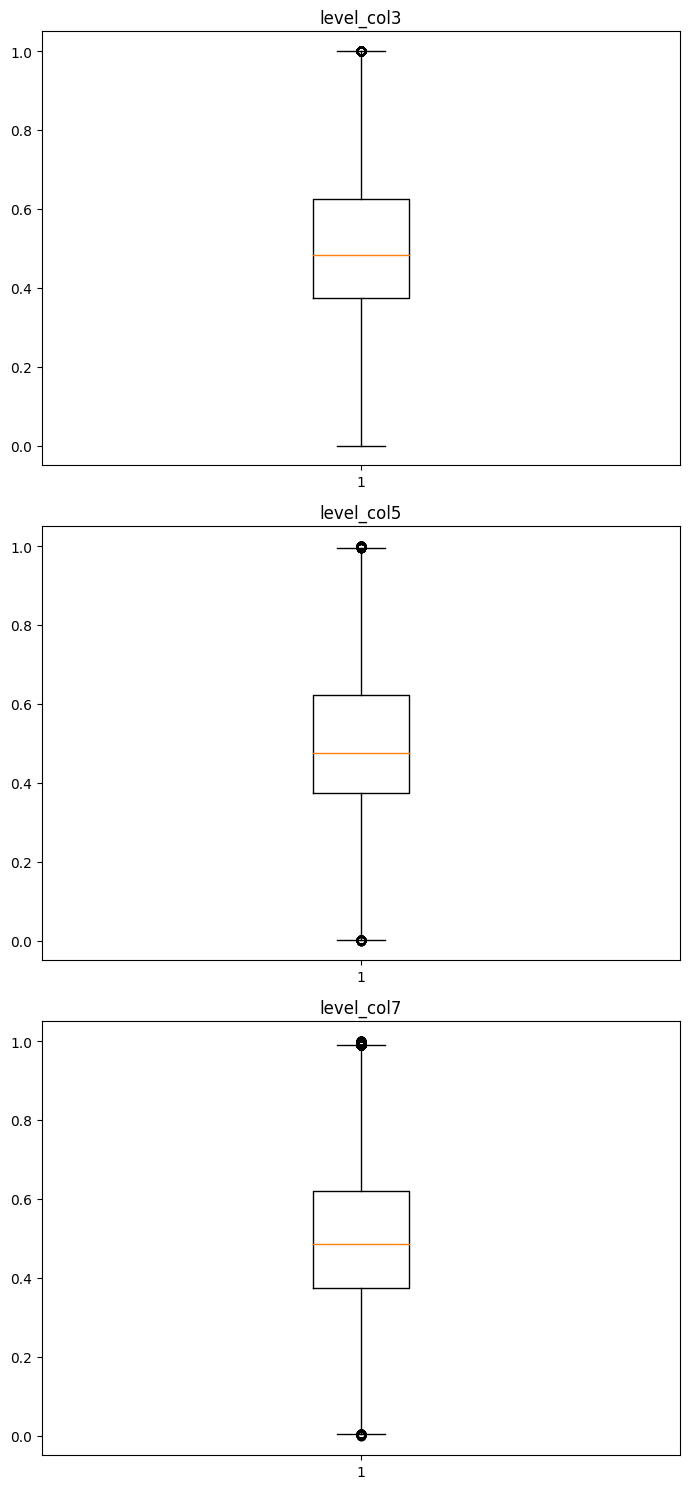

In [50]:
variables = ["level_col3", "level_col5", "level_col7"]

fig, axes = plt.subplots(3, 1, figsize=(7, 15))

for i, variable in enumerate(variables):
    plt.subplot(3, 1, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

###**5.5. Check target variable outliers**

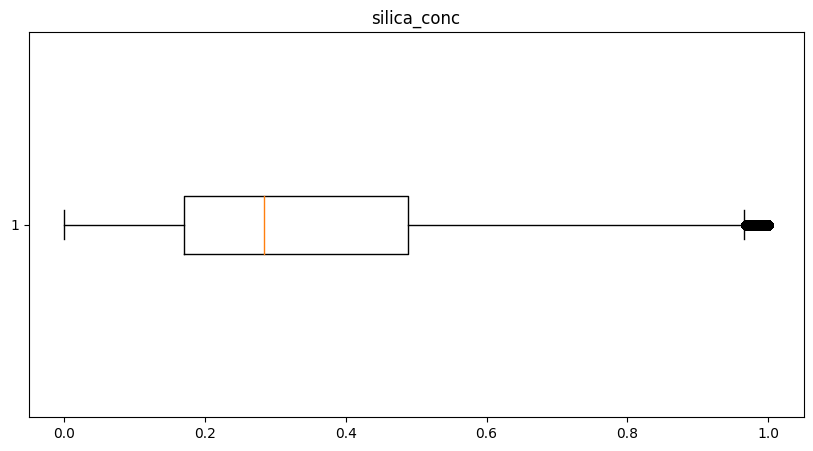

In [51]:
data = flotation["silica_conc"]
plt.figure(figsize=(10, 5))
plt.boxplot(data, vert=False)
plt.title("silica_conc")

plt.show()

- Eliminate target variable outliers by winsorizing

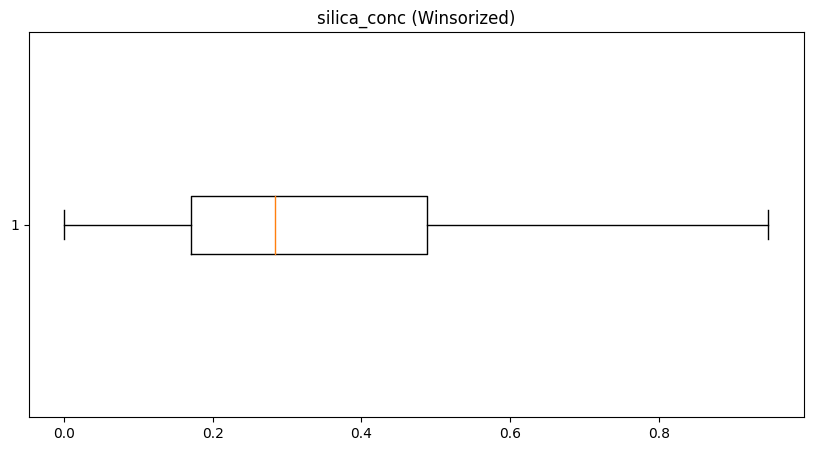

In [52]:
data_winsorized = winsorize(flotation["silica_conc"], limits=[0, 0.01])
plt.figure(figsize=(10, 5))
plt.boxplot(data_winsorized, vert=False)
plt.title("silica_conc (Winsorized)")

plt.show()

###**5.6. Check the skewness, mean and median of independent variables**

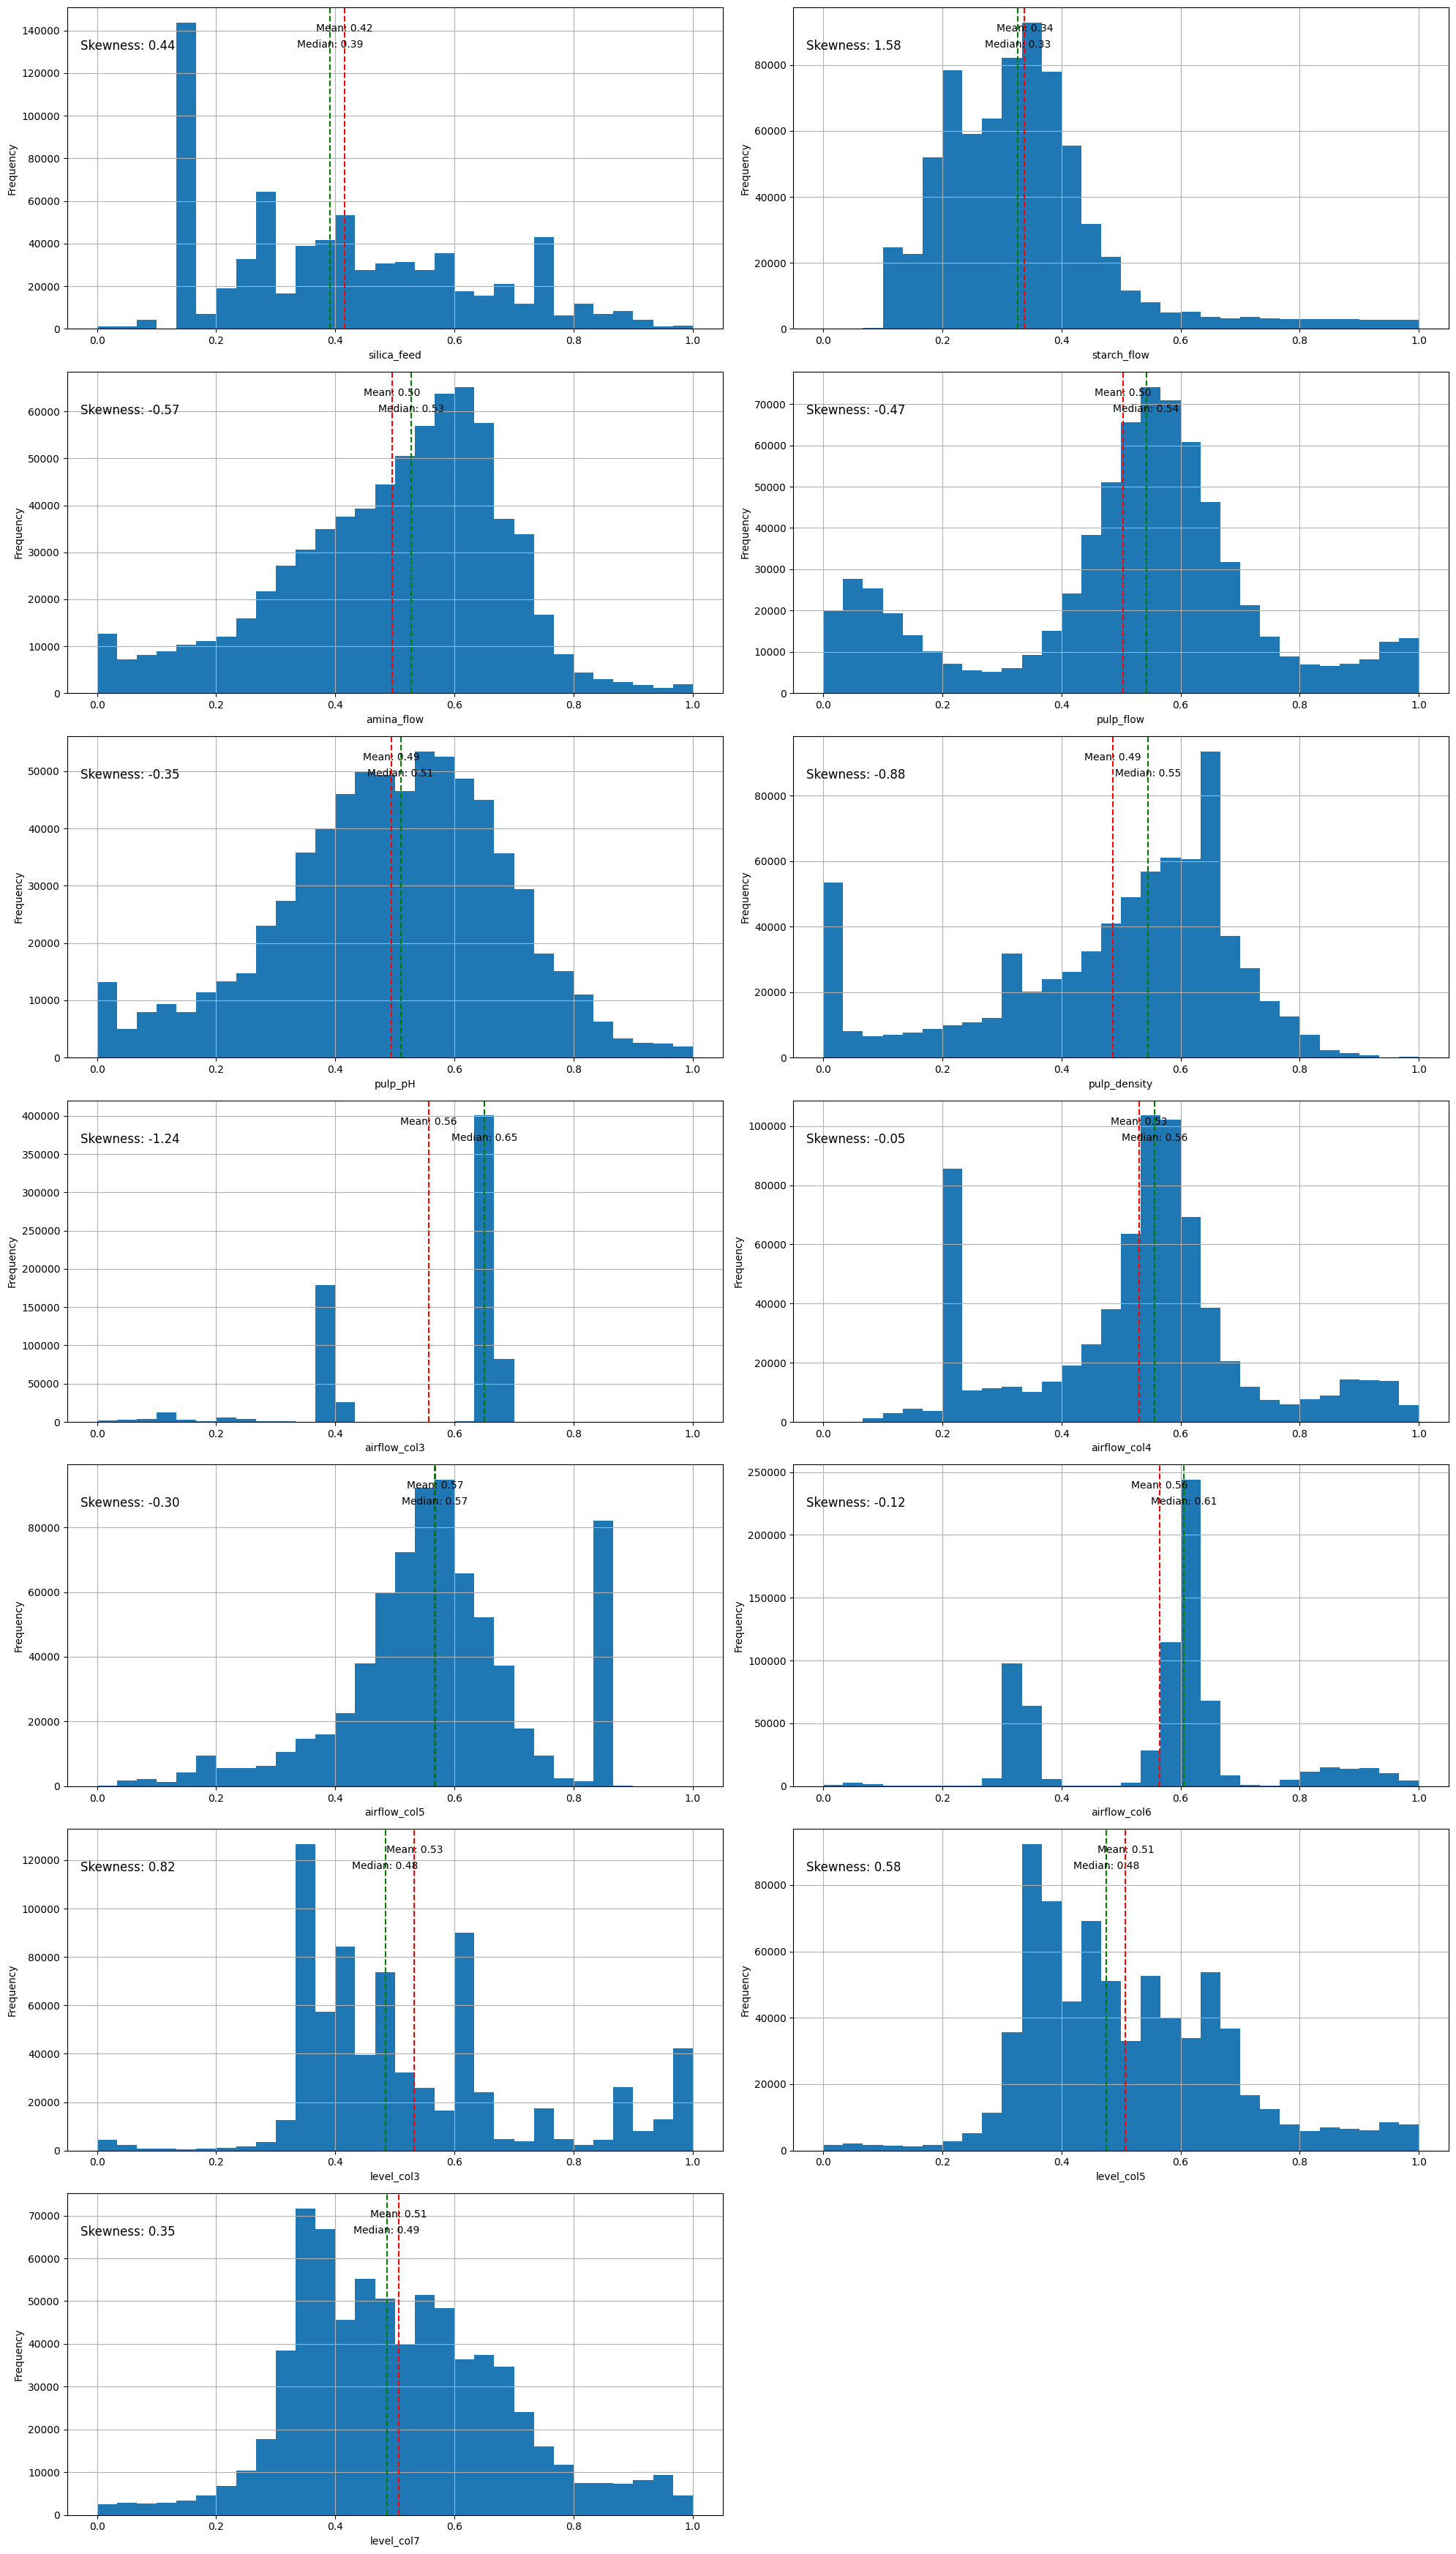

In [53]:
from scipy.stats import skew

variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col3', 'airflow_col4', 'airflow_col5',
             'airflow_col6', 'level_col3', 'level_col5', 'level_col7']

num_vars = len(variables)
num_rows = (num_vars + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 5))

for i, variable in enumerate(variables):
    # Select a specific column for skewness calculation
    data = flotation[variable].to_numpy()
    # Calculate the skewness degree
    skewness = skew(data)
    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plotting the variable in the corresponding subplot
    axes[row, col].hist(data, bins=30)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel("Frequency")
    axes[row, col].axvline(np.mean(data), color='r', linestyle='--')
    axes[row, col].axvline(np.median(data), color='g', linestyle='--')
    # Display the skewness degree in the plot frame
    axes[row, col].text(0.02, 0.9, f"Skewness: {skewness:.2f}",
                        transform=axes[row, col].transAxes, 
                        fontsize=12, verticalalignment='top')
    # Display the mean and median value
    ylim = axes[row, col].get_ylim()
    y_range = ylim[1] - ylim[0]
    axes[row, col].text(np.mean(data), ylim[1] - 0.05 * y_range,
                        f"Mean: {np.mean(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
    axes[row, col].text(np.median(data), ylim[1] - 0.1 * y_range,
                        f"Median: {np.median(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
    axes[row, col].grid(True)

if num_vars % 2 != 0:
    axes[num_rows - 1, 1].axis('off')

plt.tight_layout()
plt.show()

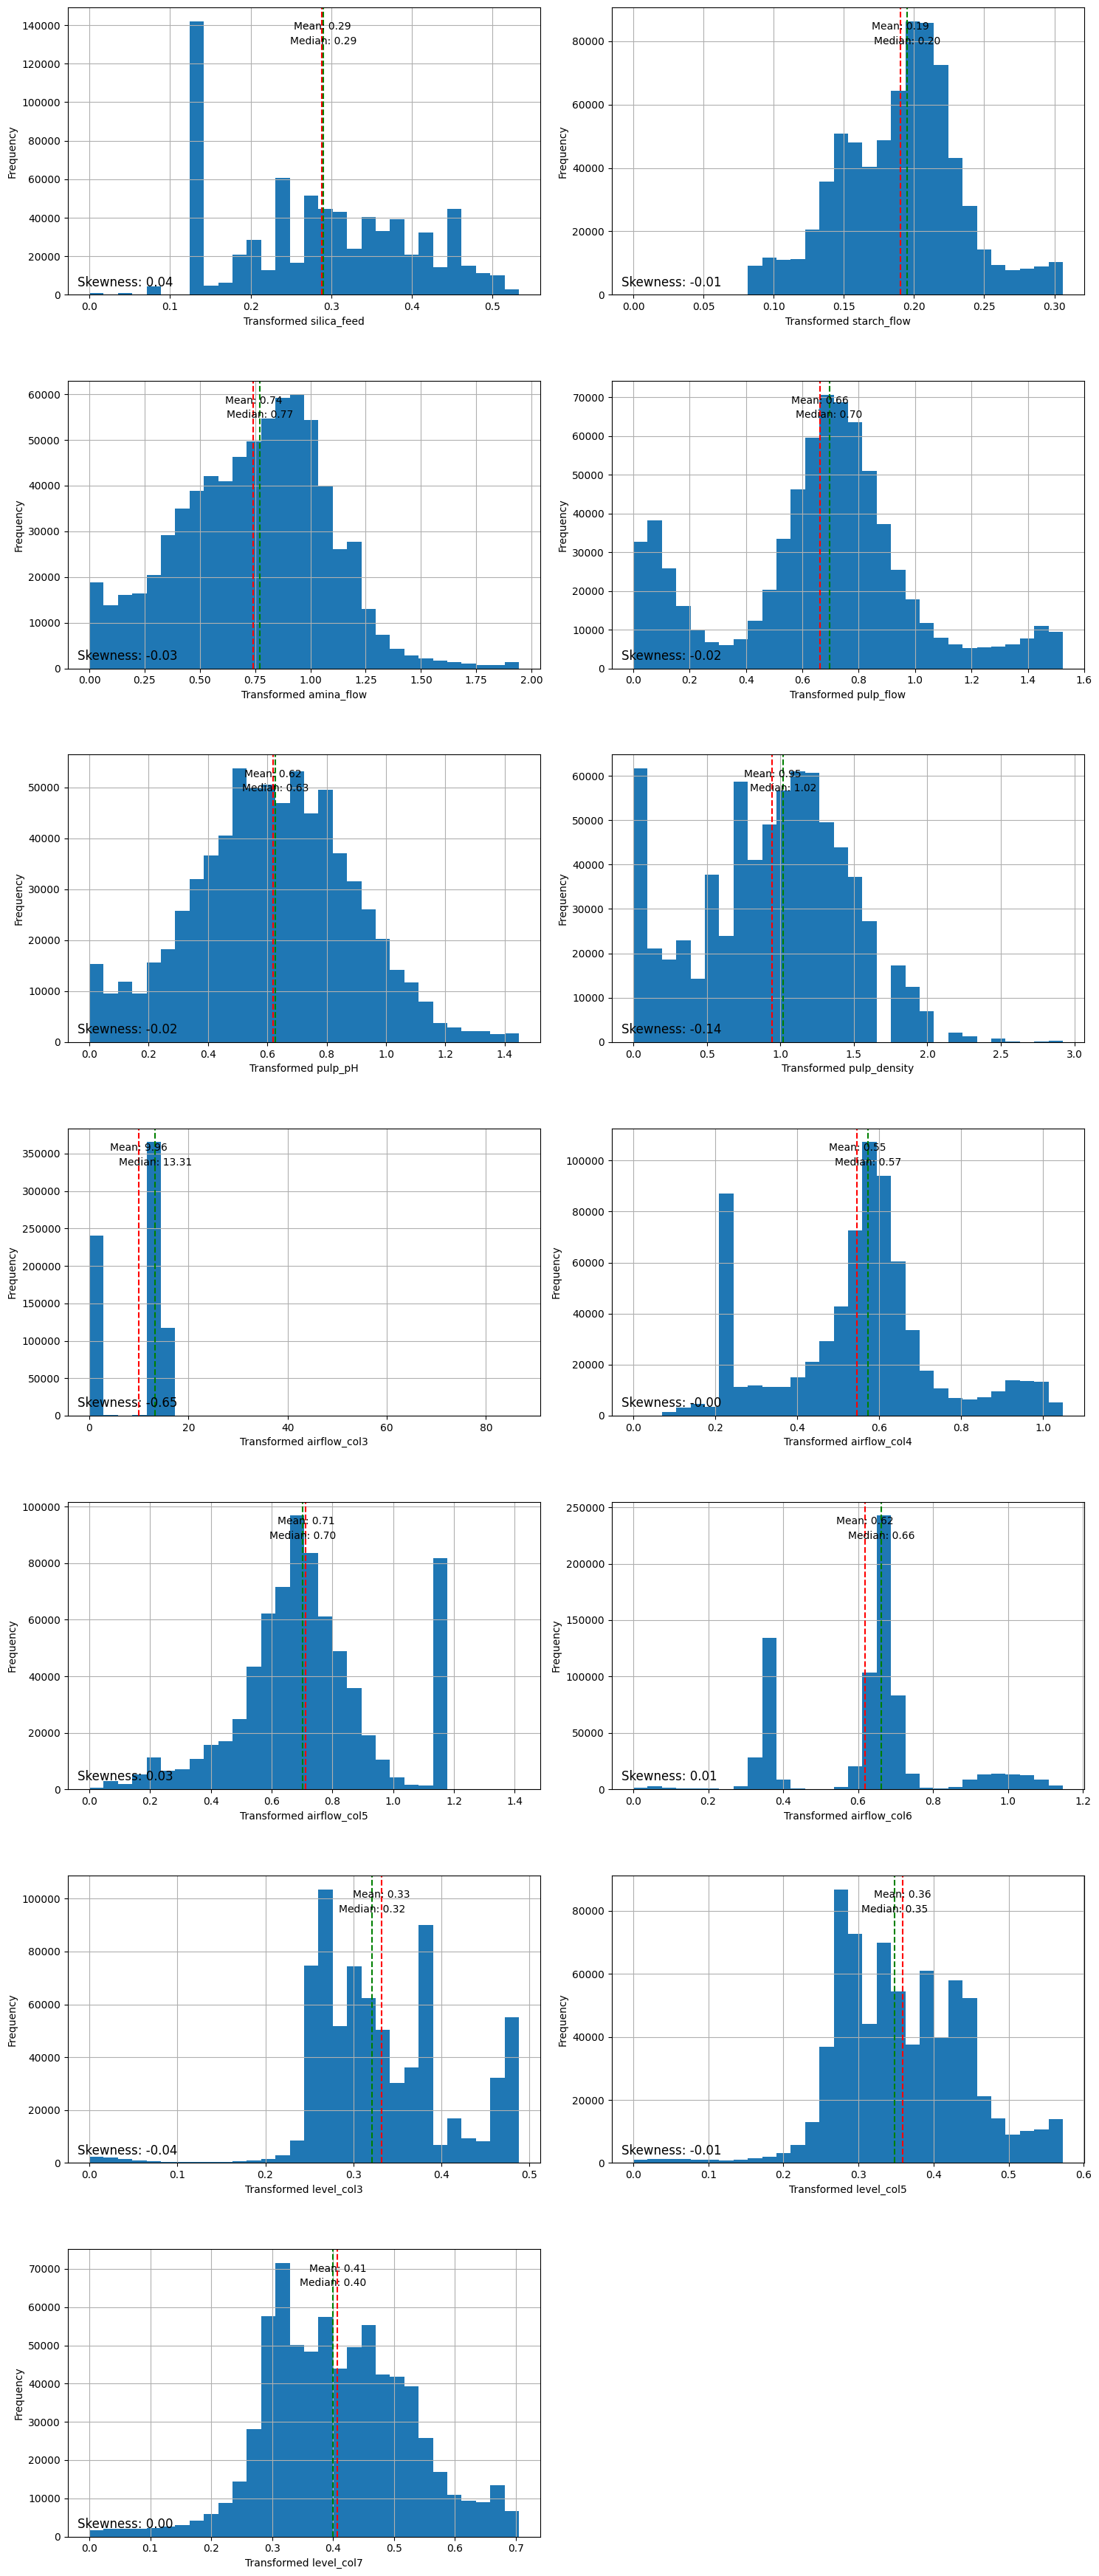

In [54]:
from scipy.stats import boxcox
from scipy.stats import skew

variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col3', 'airflow_col4', 'airflow_col5',
             'airflow_col6', 'level_col3', 'level_col5', 'level_col7']

num_variables = len(variables)
num_rows = num_variables // 2 + num_variables % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2
    
    # Select the specific column for transformation
    data = flotation[variable].to_numpy()
    
    # Shift the data by a constant value
    shifted_data = data - np.min(data) + 1  # Add 1 to ensure all values are positive
    
    # Apply the Box-Cox transformation
    data_transformed, lambda_value = boxcox(shifted_data)
    
    # Update the column in the 'flotation' DataFrame with the transformed values
    flotation[variable] = data_transformed
    
    # Calculate the skewness of the transformed data
    skewness_transformed = skew(data_transformed)
    
    # Plot the histogram of the transformed data
    axes[row, col].hist(data_transformed, bins=30)
    axes[row, col].set_xlabel(f'Transformed {variable}')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].axvline(np.mean(data_transformed), color='r', linestyle='--')
    axes[row, col].axvline(np.median(data_transformed), color='g', linestyle='--')
    
    # Display the skewness degree in the plot
    axes[row, col].text(0.02, 0.02, f"Skewness: {skewness_transformed:.2f}", 
                        transform=axes[row, col].transAxes,
                        fontsize=12, verticalalignment='bottom', 
                        horizontalalignment='left')
    
    # Display the mean and median values
    ylim = axes[row, col].get_ylim()
    y_range = ylim[1] - ylim[0]
    axes[row, col].text(np.mean(data_transformed), ylim[1] - 0.05 * y_range,
                 f"Mean: {np.mean(data_transformed):.2f}", color='black', fontsize=10,
                 verticalalignment='top', horizontalalignment='center')
    axes[row, col].text(np.median(data_transformed), ylim[1] - 0.1 * y_range,
                 f"Median: {np.median(data_transformed):.2f}", color='black', fontsize=10,
                 verticalalignment='top', horizontalalignment='center')
    axes[row, col].grid(True)

if num_variables % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

###**5.7. Check the skewness, mean and median of target variables**

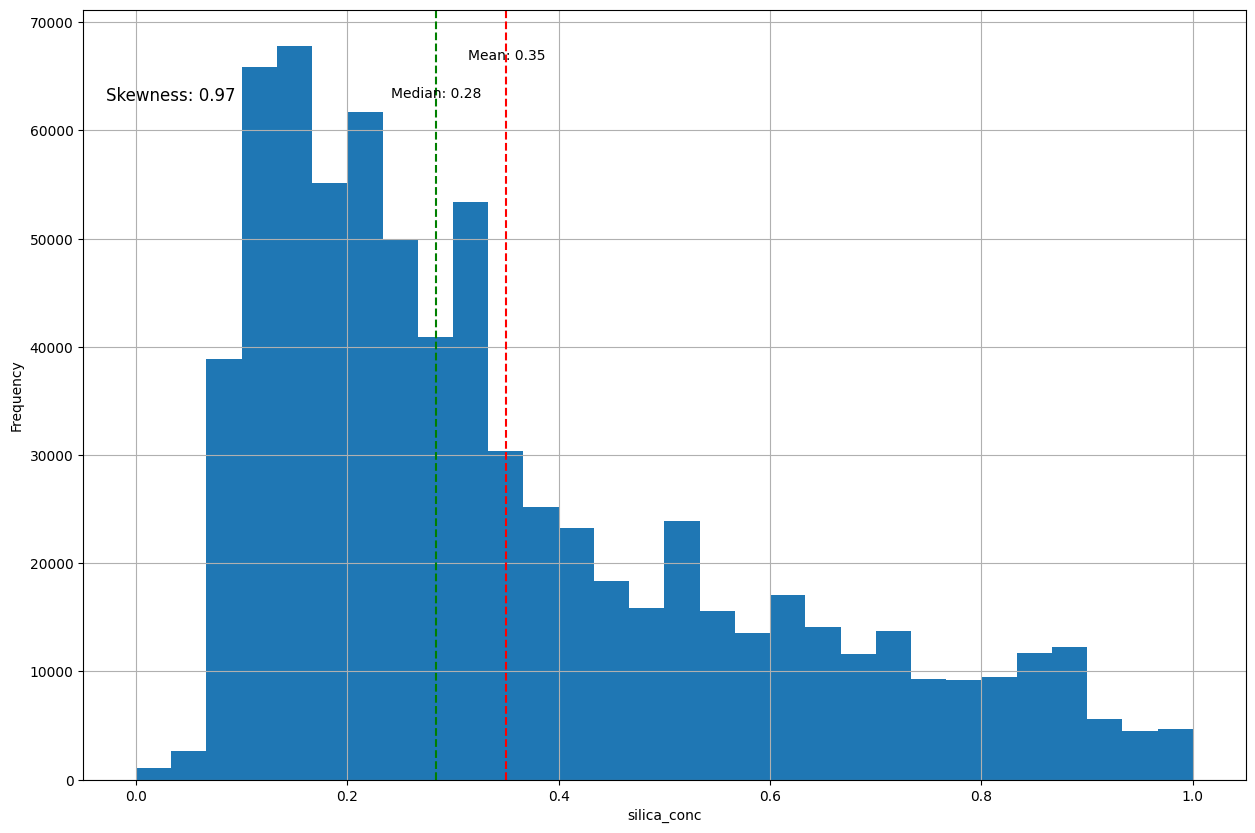

In [55]:
from scipy.stats import skew

# Select the specific column for skewness calculation
data = flotation['silica_conc'].to_numpy()

# Calculate the skewness degree
skewness = skew(data)

fig, ax = plt.subplots(figsize=(15, 10))

# Plot the histogram
ax.hist(data, bins=30)
ax.set_xlabel('silica_conc')
ax.set_ylabel('Frequency')
ax.axvline(np.mean(data), color='r', linestyle='--')
ax.axvline(np.median(data), color='g', linestyle='--')

# Display the skewness degree in the plot
ax.text(0.02, 0.9, f"Skewness: {skewness:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top')

# Display the mean and median values
ylim = ax.get_ylim()
y_range = ylim[1] - ylim[0]
ax.text(np.mean(data), ylim[1] - 0.05 * y_range,
         f"Mean: {np.mean(data):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')
ax.text(np.median(data), ylim[1] - 0.1 * y_range,
         f"Median: {np.median(data):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')
ax.grid(True)

plt.show()

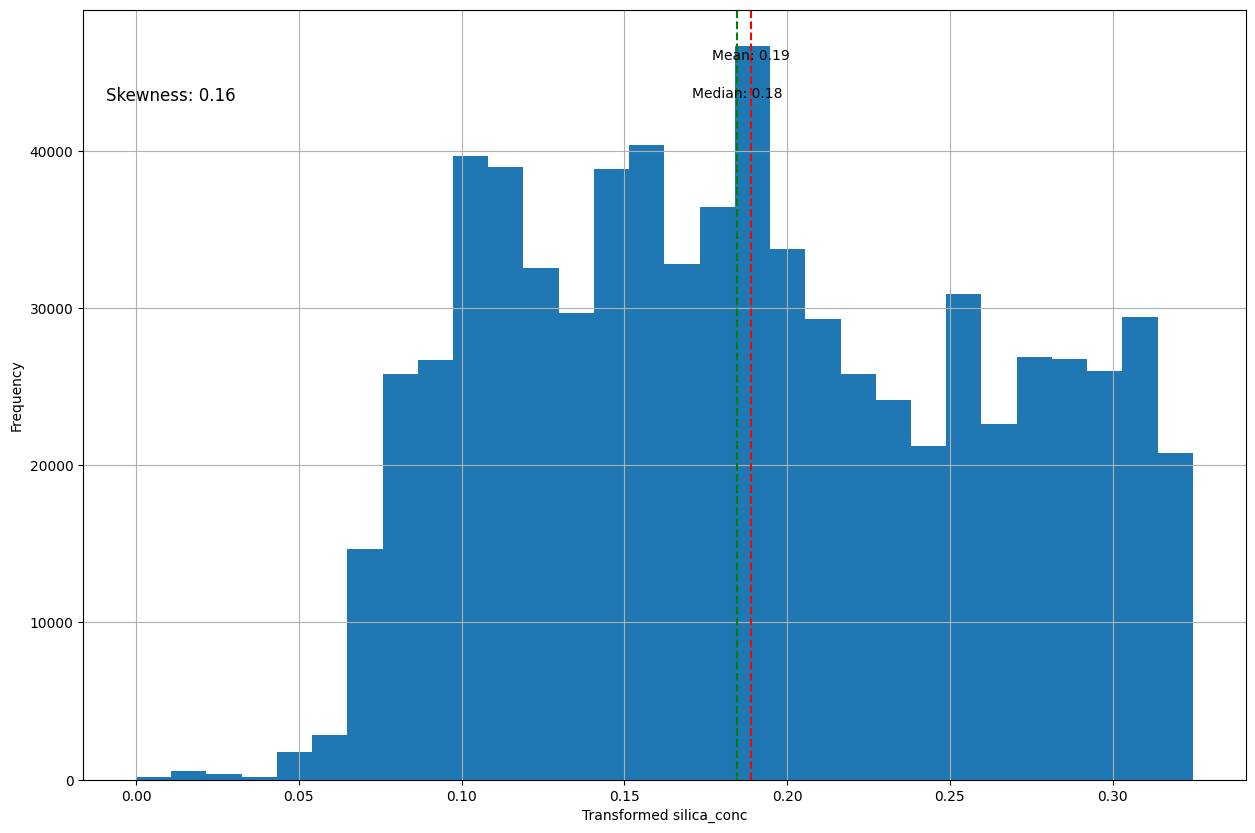

In [56]:
from scipy.stats import boxcox

# Select the specific column for transformation
data = flotation['silica_conc'].to_numpy()

# Shift the data by a constant value
shifted_data = data - np.min(data) + 1  # Add 1 to ensure all values are positive

# Apply the Box-Cox transformation
data_transformed, lambda_value = boxcox(shifted_data)

# Update the 'silica_conc' column
flotation['silica_conc'] = data_transformed

# Calculate the skewness of the transformed data
skewness_transformed = skew(data_transformed)

# Plot the histogram of the transformed data
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(data_transformed, bins=30)
ax.set_xlabel('Transformed silica_conc')
ax.set_ylabel('Frequency')
ax.axvline(np.mean(data_transformed), color='r', linestyle='--')
ax.axvline(np.median(data_transformed), color='g', linestyle='--')

# Display the skewness degree in the plot
ax.text(0.02, 0.9, f"Skewness: {skewness_transformed:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top')

# Display the mean and median values
ylim = ax.get_ylim()
y_range = ylim[1] - ylim[0]
ax.text(np.mean(data_transformed), ylim[1] - 0.05 * y_range,
         f"Mean: {np.mean(data_transformed):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')
ax.text(np.median(data_transformed), ylim[1] - 0.1 * y_range,
         f"Median: {np.median(data_transformed):.2f}", color='black', fontsize=10,
         verticalalignment='top', horizontalalignment='center')

ax.grid(True)
plt.show()

###**5.8. Save manipulated dataset to new file**

In [57]:
flotation.to_csv('/content/drive/My Drive/Flotation/Flotation_Plant_GRManipulated.csv', index=False)